In [2]:
import fceulib
import ppu_dump
import sys
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from fceu_help import pointer_to_numpy
import scipy
import scipy.misc
import cv2
import pickle

In [3]:
#rom = "mario.nes"

movie = 'speed_run.fm2'
start_t =240

rom = "mario.nes"

movie = 'leisurely.fm2'
start_t =280

emu = fceulib.runGame(rom)
inputs1 = fceulib.readInputs(movie)
inputs2 = fceulib.readInputs2(movie)

print len(inputs1)

5663


2500


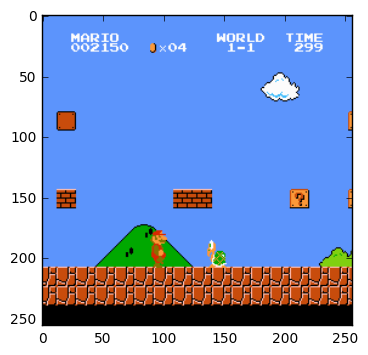

2501


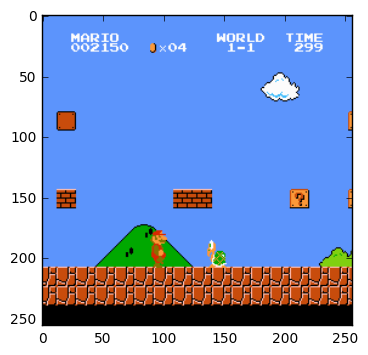

2502


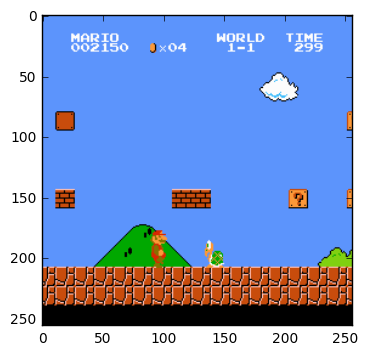

2503


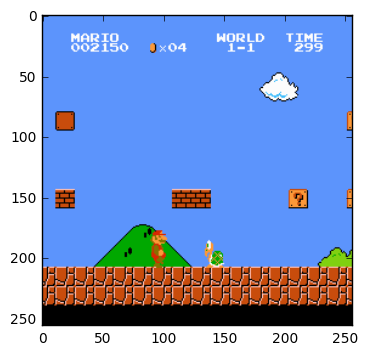

2504


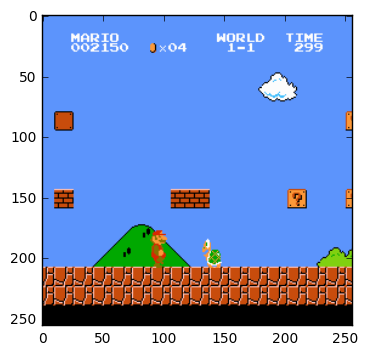

2505


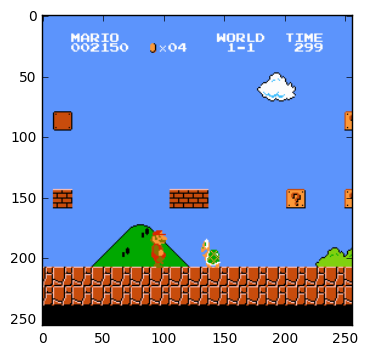

2506


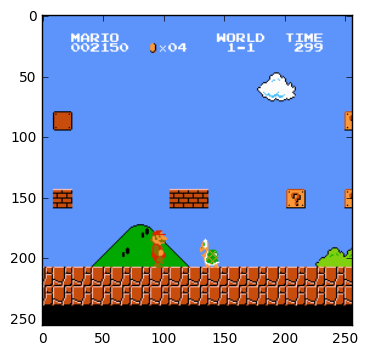

2507


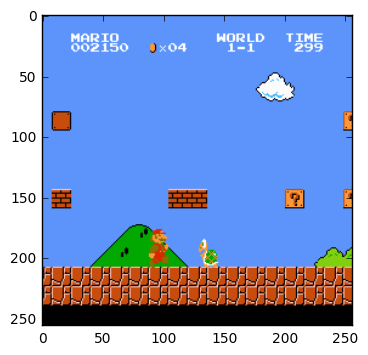

2508


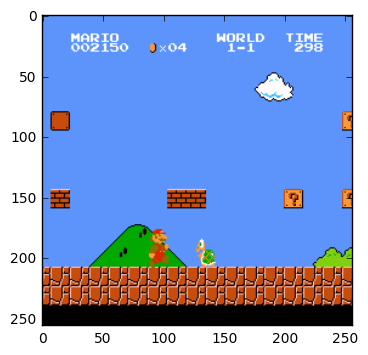

2509


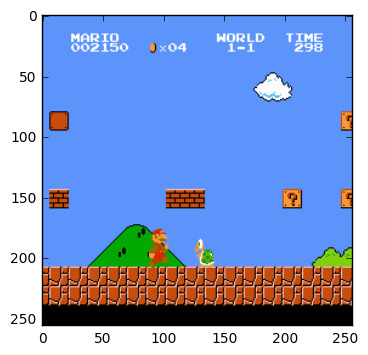

2510


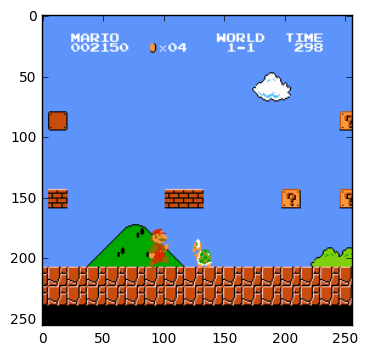

2511


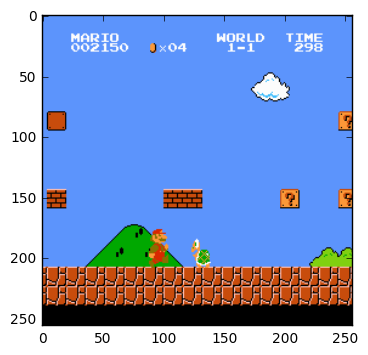

2512


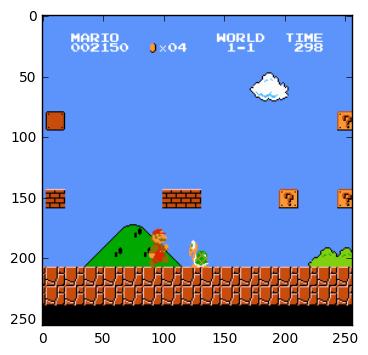

2513


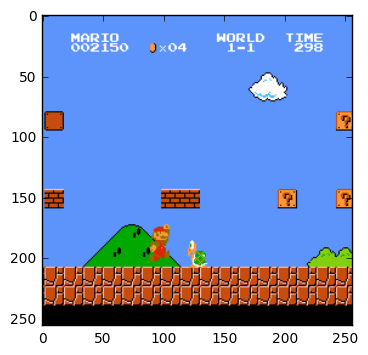

2514


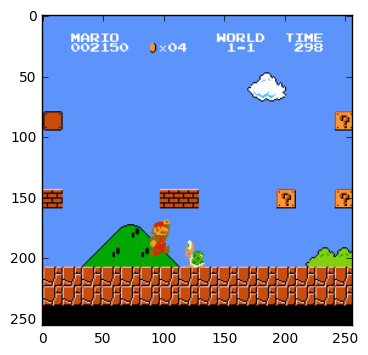

2515


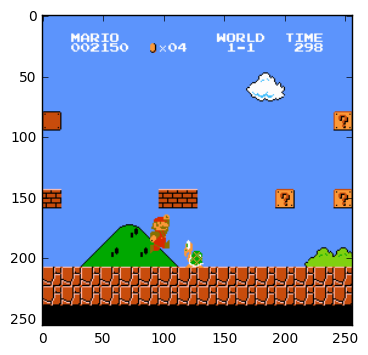

2516


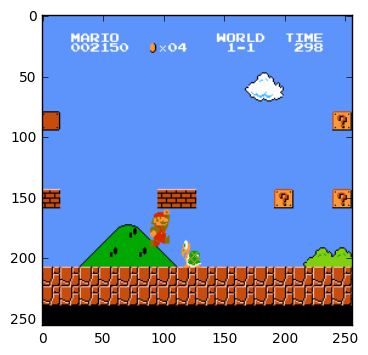

2517


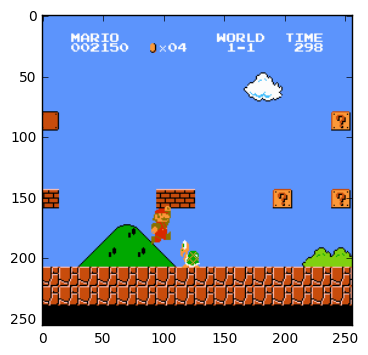

2518


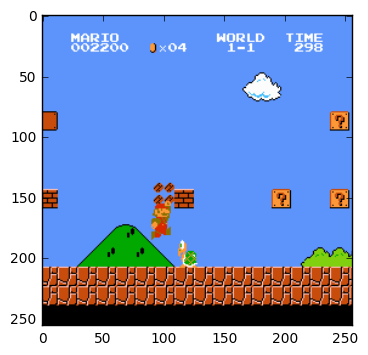

2519


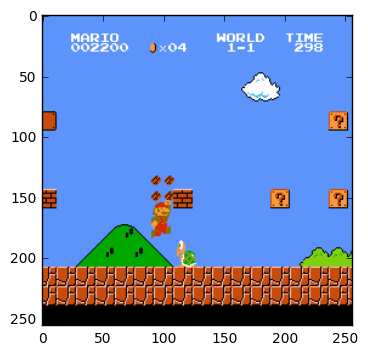

2520


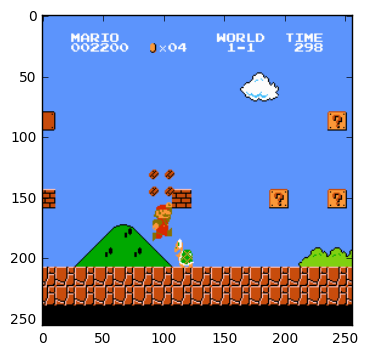

2521


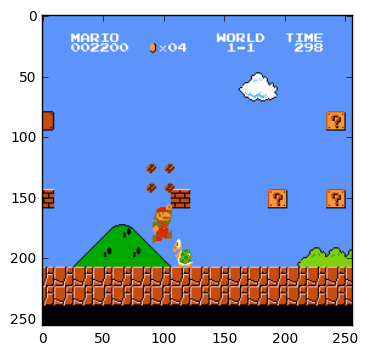

2522


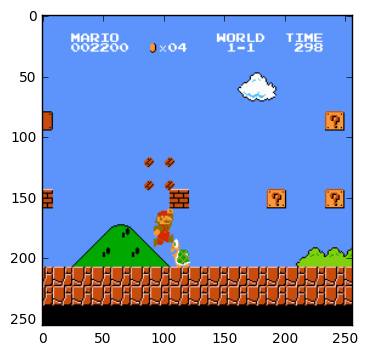

2523


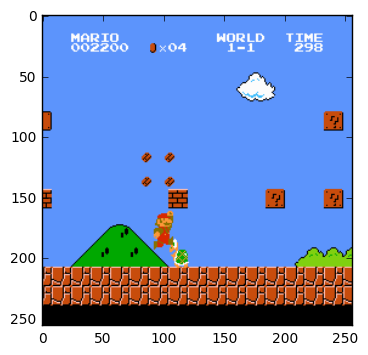

2524


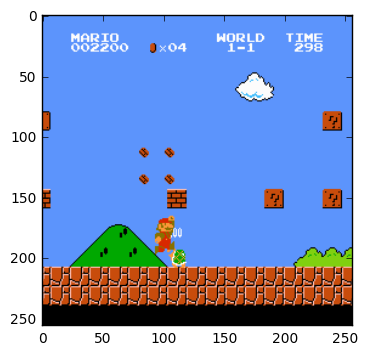

2525


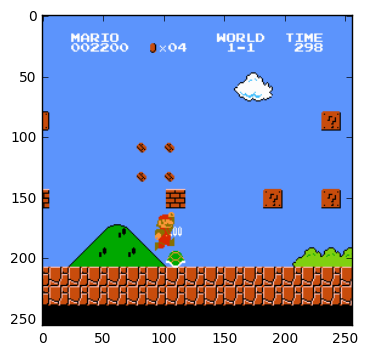

2526


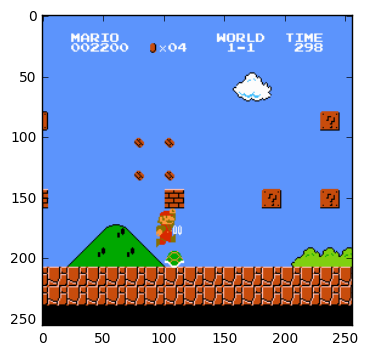

2527


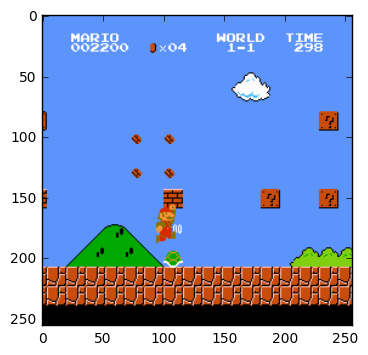

2528


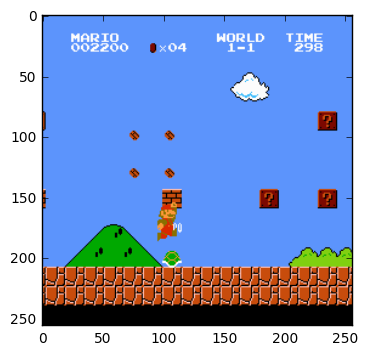

2529


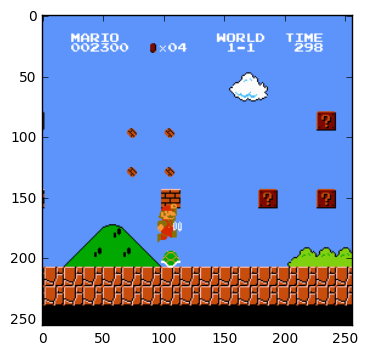

In [55]:
%matplotlib inline

start = 2500 
for t in range(start,start+30,1):

    if t == start:
        emu = fceulib.runGame(rom)
    inputs1 = fceulib.readInputs(movie)
    inputs2 = fceulib.readInputs2(movie)
    if t == start:
        for i,i2 in zip(inputs1[:start_t+t],inputs2[:start_t+t]):
            emu.stepFull(i, i2)
    else:
        i = inputs1[start_t+t]
        i2 = inputs2[start_t+t]
        emu.stepFull(i, i2)
    print t
    def convert_image(img_buffer):
        # TODO: without allocations/reshape?
        screen = pointer_to_numpy(img_buffer)
        return screen.reshape([256, 256, 4]).astype(np.uint8)

    img_buffer = fceulib.VectorBytes()
    emu.imageInto(img_buffer)
    np_image = convert_image(img_buffer)
    plt.imshow(np_image)
    plt.show()

# img = Image.fromarray(scipy.misc.imresize(np_image,1.0))
# print tesserocr.image_to_text(img) 
    